![MLTrain logo](https://mltrain.cc/wp-content/uploads/2017/11/mltrain_logo-4.png "MLTrain logo")

---------------------------------------------------------

In [33]:
%%capture --no-display
%run /Nvme/Training/MLTrainAthens/JupyterNotebooks/changeNBLayout.py

# %wget -q -O retailer.csv . . .

--------------------------
# Scope #

A large retailer asked for insights on the consumer purchasing preferences of their __fluid__ products.  
Fluids are products like shampoo, conditioner and cleaning liquids that are offered in packs of different sizes (weights | volumes).  
In particular, the retailer wanted to know  
1. the 
2. the consequences of __introducing a new size for a fluid product__  

  
<span style = "background: #E9B96E">
In the project we will investigate the effect of the <span style = "color: darkred">size composition of a sort__</span> to <b>sort sales</b>.
</span>  
A _sort_ is a collection of product items (SKUs) differing only in their sizes.

### Example ###
A type of H&S Shampoo if available in ounce-sizes 7 and 12. If I introduce a size 16oz what will be the effect on the sum of H&S sales?


# The retailer dataset #

The dataset contains numbers of items sold per week and store for each SKU.  
SKUs belong to BRANDS, SEGMENTS, TYPES and COLLECTIONS

In [2]:
import pandas as pd
import numpy as np
import sys, os
import datetime as dt

from os import linesep as endl

tab = pd.read_csv('retailer.csv', sep = '|')
display(tab.sample(10))

,SKU,GEO,WEEK_ENDING,WEEK,MONTH,PCT,PCTF,PCTD,UNITS,REVENUE,SEGMENT,TYPE,BRAND,COLLECTION,SORT,BASE_ITEM,SIZE
72186,104764,TWTUC,1985-06-13,24,6,99,0,8,17883,52545.85,SHA,SR,S,SPS,908,REG 1CT 28.0OZ,D
23938,102083,PTCTA,1983-12-22,51,12,89,0,2,816,4073.73,SHA,S2,H&S,H&SGA,385,2-IN-1 1CT 13.5OZ,C
85639,102792,TTCTA,1984-06-14,24,6,1,0,0,6,24.13,SHA,S2,DM,DMF&C,983,2-IN-1 1CT 12.0OZ,C
86594,103098,TWTUC,1984-03-01,9,3,22,0,2,568,1463.67,SHA,SR,S,SPSM,1007,REG 1CT 12.6OZ,C
106148,103592,TTCTA,1985-02-14,7,2,94,0,0,6748,10151.06,CON,CR,S,SEC,845,REG 1CT 30.0OZ,D
70849,104778,CTCT,1982-10-14,41,10,45,0,0,1024,7089.37,SHA,S2,A,AP,965,2-IN-1 1CT 12.0OZ,C
95429,104422,PTCTA,1986-01-02,1,1,83,43,2,745,2283.65,SHA,SR,S,SPSM,1007,REG 1CT 12.6OZ,C
99236,103618,TTCTA,1986-01-16,3,1,93,72,0,3056,14917.46,SHA,SR,S,SPC,1097,REG 1CT 28.0OZ,D
18461,102570,TWTUC,1984-11-29,48,11,63,0,3,3248,15942.43,CON,CR,H&S,H&SIS,376,REG 1CT 13.5OZ,C
53865,102103,TTCTA,1983-08-25,34,8,1,0,0,6,6.18,CON,CR,S,SNA&S,861,REG 1CT 12.6OZ,C


How about the types of the data?

In [3]:
tab.dtypes

SKU              int64
GEO             object
WEEK_ENDING     object
WEEK             int64
MONTH            int64
PCT              int64
PCTF             int64
PCTD             int64
UNITS            int64
REVENUE        float64
SEGMENT         object
TYPE            object
BRAND           object
COLLECTION      object
SORT             int64
BASE_ITEM       object
SIZE            object
dtype: object

Everything seems to have been read properly exept from WEEK_ENDING.  
It is a date column but has been read as string (type 'object' in DataFrames)

We can either re-read retailer.csv and explicitly parse WEEK_ENDING as date:
``` Python
pd.read_csv('retailer.csv', sep = '|', parse_dates = ['WEEK_ENDING'])
```
or we can convert the WEEK_ENDING column to datetime type using pandas.to_datetime function:

In [4]:
tab.WEEK_ENDING = pd.to_datetime(tab.WEEK_ENDING, format = '%Y-%m-%d')
print tab.WEEK_ENDING.dtype

datetime64[ns]


`DateFrame.describe` computes basic descriptive statistics of tab's contents

In [5]:
display(tab.describe())

,SKU,WEEK,MONTH,PCT,PCTF,PCTD,UNITS,REVENUE,SORT
count,112779.000000,112779.000000,112779.000000,112779.000000,112779.000000,112779.000000,112779.000000,112779.000000,112779.000000
mean,102751.378555,24.961908,6.181816,68.333254,4.534337,2.186657,5576.052102,19103.393757,689.939173
std,1504.111777,14.524046,3.341917,31.977284,16.358580,5.421718,8459.402683,25958.044088,289.565226
min,100009.000000,1.000000,1.000000,1.000000,0.000000,0.000000,5.000000,1.270000,356.000000
25%,101462.000000,13.000000,3.000000,48.000000,0.000000,0.000000,638.000000,2676.925000,385.000000
50%,102862.000000,24.000000,6.000000,81.000000,0.000000,0.000000,2539.000000,11185.930000,842.000000
75%,103837.000000,37.000000,9.000000,95.000000,0.000000,2.000000,6998.500000,26853.630000,965.000000
max,105449.000000,52.000000,12.000000,100.000000,99.000000,69.000000,131343.000000,715352.740000,2668.000000


-------------------------------------------------------
# An analysis of attribute relations #

There're several attributes that classify SKUs: SEGMENT, TYPE, BRAND, COLLECTION, SORT and BASE_ITEM  
We want to see if subsets of the attributes constitute dimension hierarchies.  
A dimension hierarchy is a set of attributes with a 1:N relation between them.  
  
E.g. if SEGMENT, BRAND, COLLECTION constitute a dimension hierarchy then SEGMENT:BRAND and BRAND:COLLECTION should be 1:N relations  

We can search for such relations per case, i.e search for a 1:N relation between SEGMENT and BRAND:

<span style = "color: darkred; font-size: 200%; font-weight: bold;  text-decoration: underline"> 
Exercise 
</span>

Do SEGMENT and BRAND constitute a dimension hierarchy?


Doing so explicitly for each pair of attributes in datasets with even a moderate number of attributes, is cumbersome and _leads to errors_.  
Instead, let's use Python's expressiveness to construct a representation of relations with a few lines of code:

In [6]:
def cardinals(df_):
    ret = pd.DataFrame(
        data = [], 
        index = pd.MultiIndex.from_product([df_.columns] * 2, names = ['groupby', '']),
        columns = ['nunique'])
    for row in df_.columns:
        ret.loc[row] = np.array([df_.groupby(row)[col].nunique().max() for col in df_.columns]).reshape(-1, 1)
    return ret.unstack()


cardinals(tab[['SEGMENT', 'TYPE', 'BRAND', 'COLLECTION']])

nunique                        
             BRAND COLLECTION SEGMENT TYPE
groupby                                   
BRAND            1         37       2    6
COLLECTION       1          1       2    5
SEGMENT          4         99       1    5
TYPE             4         76       1    1

In one stroke we see that BRAND:COLLECTION and SEGMENT:TYPE are dimension hierarchies

----------------------------------------------------------
# Creation of SIZE-related attributes #
The object is to see if the size composition of a SORT is related to total SORT sales.  
We must therefore create proxies of a sort's SIZE composition.
  
__SIZE_NUM__ = distinct sizes per GEO, WEEK_ENDING, SORT  
__SIZE_SORT__ = A (sorted) string representation of the available sizes per WEEK_ENDING, GEO, SORT
  
the second attribute tells us not only how many SIZEs we have in each SORT a given week but also the __kinds__ of available sizes:  
e.g. for SIZE_NUM = 3 we can have SIZE_SORT = 'ABC' or 'BDE'. These 2 sorts are not the same.

In [7]:
tab['NUM_SIZE'] = tab.groupby(['SORT', 'GEO', 'WEEK_ENDING'])['SIZE'].transform('nunique')
display(tab[tab['NUM_SIZE'] > 1][['SORT', 'GEO', 'WEEK_ENDING', 'NUM_SIZE']].sample(10))

,SORT,GEO,WEEK_ENDING,NUM_SIZE
111239,1103,TWTUC,1986-05-15,2
99877,912,TWTUC,1984-11-08,2
27503,394,TWTUC,1982-05-20,2
72413,856,TTCTA,1982-10-28,2
80394,930,TWTUC,1983-08-11,3
65468,925,PTCTA,1983-07-21,2
99613,1098,TWTUC,1985-09-12,2
24681,385,TTCTA,1985-05-30,2
89655,1024,TWTUC,1985-08-15,2
19633,378,TWTUC,1985-08-29,2


`transform` is a convenience DataFrame method similar to `partition by` clauses in SQL.  
Applies a group transform to each row in the dataset, thereby creating new group columns  
  
------------------------
`SIZE_SORT` is trickier:  
We must gather the unique SIZES per SORT, concatenate them to create a string, than apply this string to each `['WEEK_ENDING', 'GEO', 'SORT']` group using `transform`.  
  
Fortunately Pandas is quite flexible in this (although not higly performant as you'll see), by permitting __custom functions in transformations__

In [8]:
%%timeit -n1 -r1
asSortedString = lambda _: ''.join(np.unique(_))

tab['SIZE_SORT'] = (tab.
    groupby(['WEEK_ENDING', 'GEO', 'SORT']).
    SIZE.
    transform(asSortedString))

1 loop, best of 1: 14 s per loop


In [9]:
display(tab.sample(10))

,SKU,GEO,WEEK_ENDING,WEEK,MONTH,PCT,PCTF,PCTD,UNITS,REVENUE,SEGMENT,TYPE,BRAND,COLLECTION,SORT,BASE_ITEM,SIZE,NUM_SIZE,SIZE_SORT
43779,102440,TWTUC,1985-09-19,38,9,32,0,0,925,4205.23,CON,CR,H&S,H&SIR,429,REG 1CT 12.8OZ,C,1,C
105224,101855,TTCTA,1983-04-14,15,4,100,0,0,10312,15832.61,SHA,SR,S,SEC,844,REG 1CT 30.0OZ,D,1,D
7644,103818,TWTUC,1986-04-10,15,4,89,0,0,5907,34701.76,SHA,S2,H&S,H&SS&S,364,2-IN-1 1CT 13.5OZ,C,4,BCDE
73367,104601,PTCTA,1984-07-26,30,7,66,0,0,1187,2124.61,CON,CR,S,SPK,930,REG 1CT 2.0OZ,A,2,AC
58289,103099,TTCTA,1984-03-15,11,3,100,0,1,8005,22176.10,SHA,SR,S,SNRM,862,REG 1CT 28.0OZ,D,1,D
100476,102147,TWTUC,1985-08-08,32,8,53,0,14,2399,8963.72,SHA,S2,DM,DMCC,1106,2-IN-1 1CT 12.0OZ,C,2,CD
61887,100366,TWTUC,1982-07-22,29,7,39,0,2,2765,7867.82,SHA,SR,S,SPS,908,REG 1CT 28.0OZ,D,2,CD
93883,103176,TWTUC,1985-05-16,20,5,91,0,0,4879,24130.37,SHA,SD,S,SPK,934,SHAM KRTN 4.3OZ,A,1,A
27536,101387,TWTUC,1982-07-15,28,7,65,0,0,7542,47243.58,SHA,S2,H&S,H&SOSPS,394,2-IN-1 1CT 23.7OZ,D,2,CD
21014,103983,CTCT,1984-09-06,36,9,40,0,0,918,7715.05,SHA,S2,H&S,H&SCC,359,2-IN-1 1CT 23.7OZ,D,4,BCDE


<span style = "color: darkred; font-size: 200%; font-weight: bold;  text-decoration: underline"> 
Exercise 
</span>  
Another interesting issue is the dependency a SORT may have on the number of available sizes in the SORT. E.g. assume that a product has 5 possible SIZES and 2 are only available.  
Is this the same as having 2 sizes for a product with 2 possible sizes?  
  
Create an attribute called PCT_SIZE per (GEO, WEEK_ENDING, SORT) that contains the % percentage in relation with the total number of sizes available for the SORT

-------------------------------------------------------------------------------------------
# Creation of UNITS and REVENUE related attributes #

### UNITS ###
The way retailer.csv provides the items sold per GEO and WEEK_ENDING (UNITS field) is cumbersome:  
  
1. GEO is not a store's location but a the name of a distribution channel!  
2. UNITS then, is the number of SKUs sold through a channel's stores (channels have different number of stores).  
3. There is no indication of the number of stores per channel. Rather the field PCT contains the __percentage__ of the stores in a channel that a given SKU was available in a certain WEEK_ENDING.  
  
The best we can do is assume that each channel has 100 stores and use the UNITS/PCT as a target variable in our prediction task.  
We can say that we predict the units sold per GEO's __percentile store__.  
  
We use Dataframe's `where` method to divide UNITS by non-zero PCT only

In [10]:
# DO NOT forget to convert to float:
# Both UNITS and PCT are int. Dividing them in Python 2.x produces an int that will truncate fractional sales

tab['SALES'] = np.where(tab.PCT > 0, (1. * tab.UNITS)/tab.PCT, 0.) 
print tab.SALES.dtype

float64


### REVENUE ###
REVENUE contains the pounds collected from ALL the stores of the channel per SKU and WEEK_ENDING.  
Therefore is not sth that we can use during the prediction phase (we don't know the items sold).  
  
REVENUE/UNITS however is the avg selling price of the item and this is known during the prediction phase.

In [11]:
tab['PRICE'] = np.where(tab.UNITS > 0, tab.REVENUE / tab.UNITS, 0.)
print tab.PRICE.sample(5)

81134     4.969171
55531     7.035122
75012     2.877375
97662     5.918464
101474    2.226268
Name: PRICE, dtype: float64


------------
# EDA #

In [12]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
sns.set_context('notebook', font_scale = 1.2)

### Dataset imbalance:  ###
Observation counts per SEGMENT and {SIZE, NUM_SIZE, SORT_TYPE}: The dataset is highly biased towards sizes C and D, and sorts C, D and CD.  
Analysis will be constraint to categories with enough observations (here we will filter with SIZE_SORT C, D, CD and CDE)

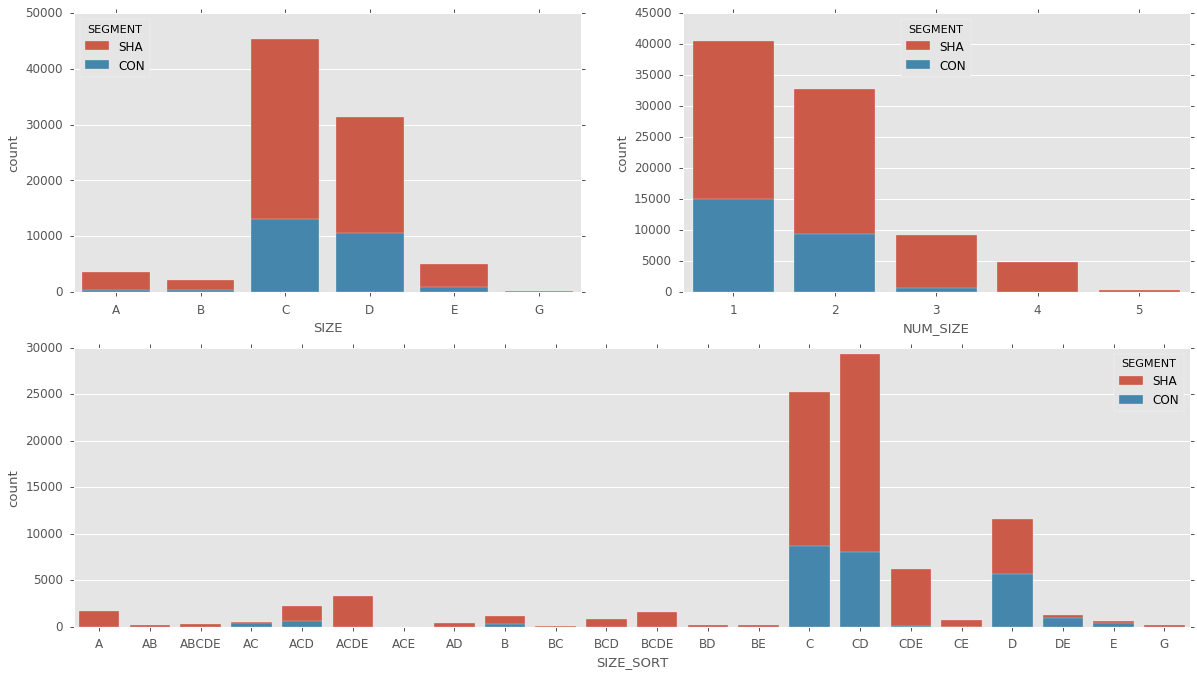

In [13]:
fig = plt.figure(figsize = [20, 11])
ax1 = fig.add_subplot(221)
sns.countplot(x = 'SIZE', hue = 'SEGMENT', data = tab.sort_values(by = 'SIZE'), ax = ax1, dodge = False)
ax2 = fig.add_subplot(222)
sns.countplot(x = 'NUM_SIZE', hue = 'SEGMENT', data = tab.sort_values(by = 'NUM_SIZE'), ax = ax2, dodge = False)
ax3 = fig.add_subplot(212)
sns.countplot(x = 'SIZE_SORT', hue = 'SEGMENT', dodge = False, ax = ax3, data = tab.sort_values(by = 'SIZE_SORT'))

Create (a reference to) a subset of tab, containing only the SIZE_SORT values of interest:

In [14]:
tab2 = tab[tab.SIZE_SORT.isin(['C', 'D', 'E', 'CD', 'CDE'])]

### Dependency of SALES to promotions ###
PCTF and PCTD are similar to PCT and contain the percentage of stores where a product was _'Featured'_ or _'Displayed'_.  
Both featuring and display can hold for a product.  
  
A __featured__ product is sold with an extra 'feature' like another complementary (e.g. shampoo with conditioner)  
A __displayed__ product is placed in a very 'spotty' location in the store  
  
In the following we examine the relation of PCTD with SALES and display this relationship visually and with a statistical descriptive measure called __'lift'__

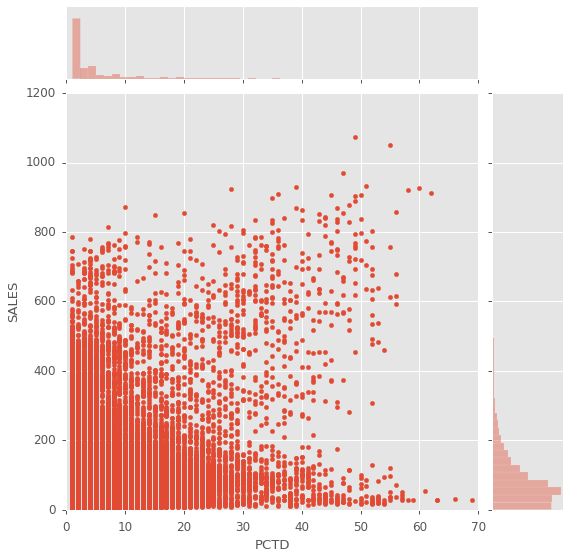

In [15]:
_ = sns.jointplot(x = 'PCTD', y = 'SALES', data = tab2[tab2.PCTD > 0.], size = 8, stat_func = None)

<span style = "color: darkred; font-size: 200%; font-weight: bold;  text-decoration: underline"> 
Exercise 
</span>  
  
A lift of a scalar quantity (here SALES) wrt a binary variable V is defined as:  
$$\frac{\mathtt {AVG(quantity)\, for\, V = 1}}{\mathtt {AVG(quantity)\, for\, V = 0}}$$

Calculate the lift of sales for PCTD > .2 versus PCTD <= .2


### Elaborating on SIZE_SORT ###
The relation of the size composition of a sort to sort's sales is a bit involved.  
  
A question is:  
'Given that a size is available for sale, what size sorts (containing this size) sell more?'
  
The following diagram uses seaborn's ploting tools to display a breakdown of AVG sales per SIZE_SORT for each combination of BRAND and SIZE
There's visual evidence that the co-existence CD and CDE increases AVG SALES.

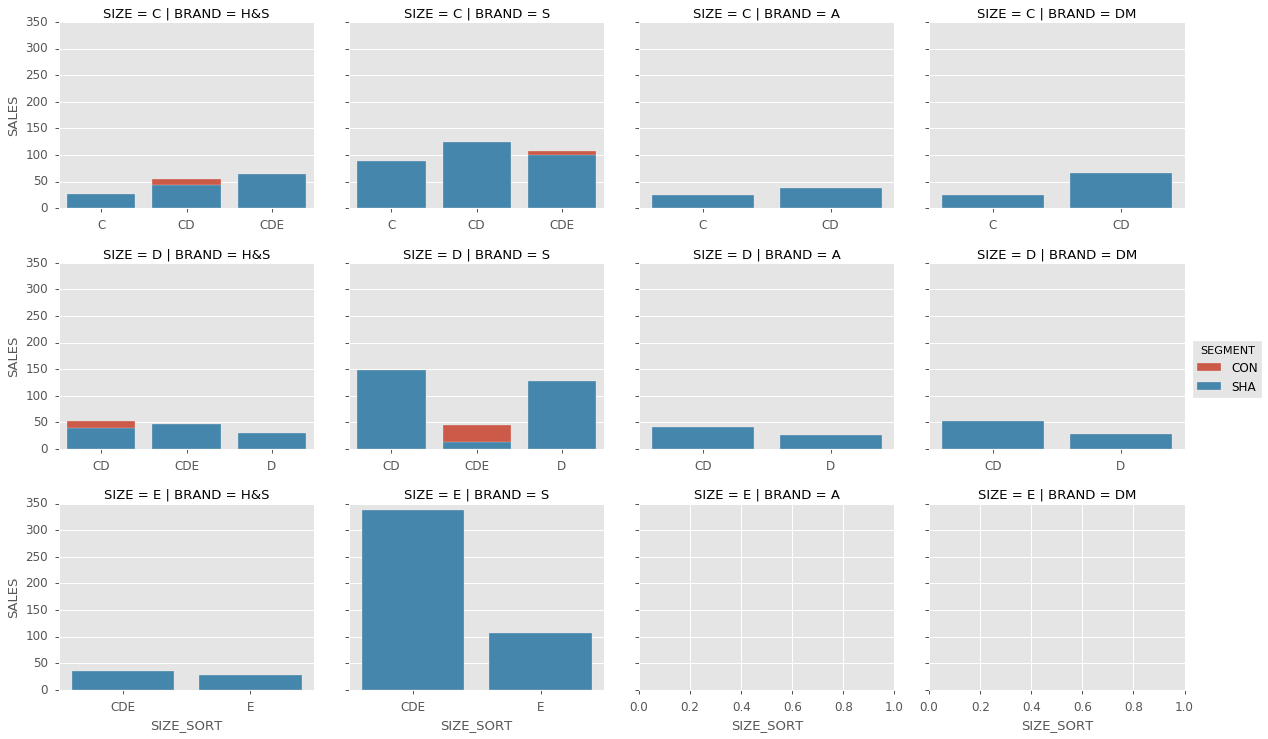

In [32]:
tab3 = tab2.groupby(['SEGMENT', 'BRAND', 'SIZE', 'SIZE_SORT'], as_index = False)['SALES'].mean()
fg = sns.FacetGrid(
    tab3,
    row = 'SIZE', col = 'BRAND', hue = 'SEGMENT', size = 3.5, aspect = 1.2, sharex = False)
_ = fg.map(sns.barplot, 'SIZE_SORT', 'SALES').add_legend()

-------------------------
# Conclusions #

DataFrames and matplotlib-seaborn systems are very powerfull for doing EDA on moderately-sized datasets.  
the problem is that the data must reside in memory, however this is easily aleviated using PySpark or increasing the available memory.  
  
Beyond the technical matters, __the most important caveat I of visual analysis and descriptive stats is that:__    
<div style = "background: #E9B96E">
in the real world there're __no obvious relationships between data__.  
Most of the examples you see in courses use datasets with obvious relations between a few fields in the observations.  
In reality the dependencies are more complex and involve __many__ fields so that it is difficult to discover them visually.
</div>  
  
The answer is __Machine Learning__  
We let the algorithm find intricate relationships among multiple fields and rest with the fact that this is better an eye can do  
  
In the ML notebook we'll see that it is preferable to employ a regression tree do a whatif analysis automatically for any size assortment, brand, promo and week we like